**Quantum solution of the 1D Advection equation**

Done by: Hussein Shiri

In [1]:
#!pip install pennylane

### Discretization:
The 1D pde Advection equation has the form:
$\frac{du}{dt} + c\frac{du}{dx} = 0$.

By discretizing this pde, we will get the form $Au^{n+1} = u^{n}$.

Where $A$ is a tridiagonal matrix in which the diagonal and above and below the diagonal just directly are filled, so we have 3 filled lines in the matrix.

In addition to that, $u^n$ is the initial vector and we need to find $u^{n+1}$.

To discretize we will use the following:

1. Second-order central difference in space: $c\frac{du}{dx}|^{n+1}_i = c(\frac{u_{i+1}^{n+1} - u_{i-1}^{n+1}}{2Δx}) $. It is called second order because the truncation error (difference between the exact and discrete pde) is proportional to $(Δx)^2$.

2. First-order implicit time discretization: $\frac{du}{dt}|_{t_{n}} = \frac{u_{i}^{n+1} - u_{i}^{n}}{Δt} $. It is called first order because the truncation error is proportional to $Δt$.

After expanding we get the following equation: $-\frac{C}{2} u_{i-1}^{n+1} + u_{i}^{n+1} + \frac{C}{2} u_{i+1}^{n+1} = u_{i}^{n}$

Where C = $c\frac{Δt}{Δx}$.

The $u^{n+1}$ terms with:
1. $i$ are on the diagonal.
2. $i+1$ directly above the diagonal.
3. $i-1$ directly below the diagonal.

Finally we get $A$:

\begin{pmatrix}
1 & \frac{C}{2} & 0 & \dots & 0 & 0 \\
-\frac{C}{2} & 1 & \frac{C}{2} & \dots & 0 & 0 \\
0 & -\frac{C}{2} & 1 & \dots & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & \dots & 1 & \frac{C}{2} \\
0 & 0 & 0 & \dots & -\frac{C}{2} & 1
\end{pmatrix}

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [3]:
n = 16
c = 1
delta_t = 0.01
delta_x = 0.1
C = c*delta_t/delta_x
A = np.zeros((n, n))

np.fill_diagonal(A, 1.0)

i = 0
# A[i, i+1] = C/2
for i in range(n - 1):
  A[i, i + 1] = C / 2.0

i = 1
# A[i, i-1] = -C/2
for i in range(1, n):
  A[i, i - 1] = -C / 2.0

In [4]:
def printA(a):
    for row in a:
        for col in row:
            print("{:8.3f}".format(col), end=" ")
        print("")
printA(A)

   1.000    0.050    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000 
  -0.050    1.000    0.050    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000 
   0.000   -0.050    1.000    0.050    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000 
   0.000    0.000   -0.050    1.000    0.050    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000 
   0.000    0.000    0.000   -0.050    1.000    0.050    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000 
   0.000    0.000    0.000    0.000   -0.050    1.000    0.050    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000 
   0.000    0.000    0.000    0.000    0.000   -0.050    1.000    0.050    0.000    0.000    0.000    0.000    0.000    0.000    0

By using the above 16x16 matrix we need 4 qubits as $2^4 = 16$.

The next thing we need to know is what the $u^{n+1}$ and $u^{n}$ vectors are.

Let us start with $u_n$, using the Dirichlet boundary conditions imposed on the pde which leads to the values that the solution takes along the boundary of the domain being fixed.

\begin{pmatrix}
u_1^n + \frac{C}{2} u_0^{n+1} \\
u_2^n \\
u_3^n \\
\vdots \\
u_{N-1}^n \\
u_N^n - \frac{C}{2} u_{N+1}^{n+1}
\end{pmatrix}

we get the first and last values of this vector by substituting i by 1 and N:

1. at i = 1: $u_1^{n+1} + \frac{C}{2} u_2^{n+1} = u_1^n + \frac{C}{2} u_0^{n+1}$

2. at i = N: $-\frac{C}{2} u_{N-1}^{n+1} + u_N^{n+1} = u_N^n - \frac{C}{2} u_{N+1}^{n+1}$

The vector $u^{n+1}$ is simply:

\begin{pmatrix}
u_1^{n+1} \\
u_2^{n+1} \\
u_3^{n+1} \\
\vdots \\
u_N^{n+1}
\end{pmatrix}

The $u^n$ vector is pre-given from previous initial steps or knowledge. We will generate a new one using the following way:
\begin{pmatrix}
\sin\left(\frac{\pi x_1}{L}\right) + \frac{C}{2}U_{left}\\
\sin\left(\frac{\pi x_2}{L}\right) \\
\vdots \\
\sin\left(\frac{\pi x_{N-1}}{L}\right) \\
\sin\left(\frac{\pi x_N}{L}\right) - \frac{C}{2}U_{right}
\end{pmatrix}
The $\sin()$ function is simple and smooth. The characteristic of being smooth is important for classical solvers that require differentiability.

A function is considered "smooth" if it is not just differentiable once, but multiple times, and all these derivatives are themselves continuous.

In [5]:
#Implementing the U_n vector
U_n = np.zeros(n) # Initialize as a 1D array
U_left = 1
U_right = 0
L = 4

U_n[0] = np.sin(np.pi * delta_x / L) + (C / 2) * U_left
for i in range(1, n-1):
    U_n[i] = np.sin(np.pi * i * delta_x / L)
U_n[n-1] = np.sin(np.pi * (n-1) * delta_x / L) - (C / 2) * U_right # Corrected index to n-1 for the last element

print(U_n) # Print the 1D array

[0.1284591  0.0784591  0.15643447 0.23344536 0.30901699 0.38268343
 0.4539905  0.52249856 0.58778525 0.64944805 0.70710678 0.76040597
 0.80901699 0.85264016 0.89100652 0.92387953]


### Solving using QLVS:
The general steps are:

1. Defining ansatz circuit.
2. Defining cost function.
3. Training using a classical optimizer to decrease the value of the cost.

In [ ]:
cost_history = []

dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def ansatz(weights):
  qml.StronglyEntanglingLayers(weights, wires = range(4))
  return qml.state()

def cost(weights, u, mtrx):
  predictions = ansatz(weights)

  dot_product_result = mtrx @ np.asarray(predictions)

  difference = dot_product_result - u

  # Calculate the squared norm using sum of squared differences
  to_return = qml.numpy.linalg.norm(difference)**2
  return to_return

optimizer = qml.AdamOptimizer(stepsize=0.1)
epochs = 250

weights_shape = qml.StronglyEntanglingLayers.shape(n_layers=10, n_wires=4)
initial_weights = np.random.rand(*weights_shape)

print(f"Shape of initial_weights: {initial_weights.shape}, Dtype: {initial_weights.dtype}")
weights = qml.numpy.array(initial_weights, requires_grad=True)


# Convert U_n and A to qml.numpy arrays before the optimization loop
U_n = qml.numpy.array(U_n, dtype=float)
A = qml.numpy.array(A, dtype=float)

for epoch in range(epochs):
    weights, current_cost = optimizer.step_and_cost(cost, weights, U_n, A)
    weights = weights[0]
    cost_history.append(current_cost)
    print(f"Epoch {epoch + 1}/{epochs}, Cost: {current_cost:.4f}")

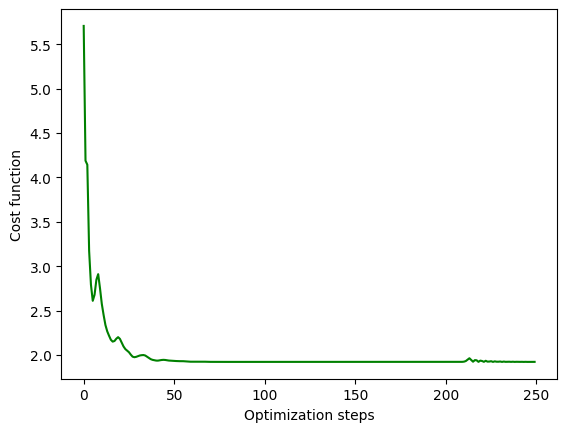

In [7]:
cost_values = [float(c) for c in cost_history]
plt.plot(cost_values, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

### Classical Solution

Using the classical solver is very important in order to compare the classical solution with the quantum one.

In [8]:
#import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

# --- 1. The known vector at time n (u_n) ---
# Let's assume a problem with 16 spatial points (e.g., 1D PDE)
# So, u_n will be a vector of size 16
print(f"Vector at time n (u_n):\n{U_n}\n")

# --- 2. The sparse matrix A ---
# We'll use the same previous matrix A: a tridiagonal matrix,
# which arises from finite difference discretizations of 1D PDEs.
# A tridiagonal matrix has non-zero elements only on the main diagonal
# and the diagonals immediately above and below it.

# Convert the matrix to CSR (Compressed Sparse Row) format for efficient solving
# CSR is generally the best format for matrix-vector products and solving linear systems.
# Corrected: Use csr_matrix from scipy.sparse
A_csr = csr_matrix(A)

print(f"Sparse Matrix A (CSR format):\n{A_csr}")
print(f"Matrix A (dense representation for clarity):\n{A_csr.toarray()}\n") # Display as dense for readability

# --- 3. Solve the linear system A * u_{n+1} = u_n ---
# The spsolve function takes the sparse matrix A and the right-hand side vector u_n
# Ensure u_n is a standard numpy array for spsolve if it's a PennyLane array
u_n_standard = np.array(U_n)
u_n_plus_1 = spsolve(A_csr, u_n_standard)

print(f"Vector at time n+1 (u_n_plus_1):\n{u_n_plus_1}\n")

# --- 4. (Optional) Verify the solution ---
# Multiply A_csr by the calculated u_n_plus_1 to see if it equals u_n
verification_result = A_csr @ u_n_plus_1
print(f"Verification (A @ u_n_plus_1):\n{verification_result}")
print(f"Difference from u_n (should be close to zero):\n{verification_result - u_n_standard}\n")

Vector at time n (u_n):
[0.1284591  0.0784591  0.15643447 0.23344536 0.30901699 0.38268343
 0.4539905  0.52249856 0.58778525 0.64944805 0.70710678 0.76040597
 0.80901699 0.85264016 0.89100652 0.92387953]

Sparse Matrix A (CSR format):
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 46 stored elements and shape (16, 16)>
  Coords	Values
  (0, 0)	1.0
  (0, 1)	0.049999999999999996
  (1, 0)	-0.049999999999999996
  (1, 1)	1.0
  (1, 2)	0.049999999999999996
  (2, 1)	-0.049999999999999996
  (2, 2)	1.0
  (2, 3)	0.049999999999999996
  (3, 2)	-0.049999999999999996
  (3, 3)	1.0
  (3, 4)	0.049999999999999996
  (4, 3)	-0.049999999999999996
  (4, 4)	1.0
  (4, 5)	0.049999999999999996
  (5, 4)	-0.049999999999999996
  (5, 5)	1.0
  (5, 6)	0.049999999999999996
  (6, 5)	-0.049999999999999996
  (6, 6)	1.0
  (6, 7)	0.049999999999999996
  (7, 6)	-0.049999999999999996
  (7, 7)	1.0
  (7, 8)	0.049999999999999996
  (8, 7)	-0.049999999999999996
  (8, 8)	1.0
  (8, 9)	0.049999999999999996
  (9, 8)	-0.0

A very important thing to notice, is that by printing the values of the classical and quantum vectors we see that they differ somehow a lot, but in fact the classical vector is not normalized. After normalizing it, the 2 vectors are approximately equal.

This is good as the solution we have used is a very basic QVLS, other solvers and algorithms exist that can provide even better more accurate results.

In [9]:
print(f"Vector at time n+1 (u_n_plus_1) classical solver:\n{u_n_plus_1}\n")

Vector at time n+1 (u_n_plus_1) classical solver:
[0.12459716 0.07723868 0.14900546 0.22581877 0.30153735 0.37541169
 0.44697223 0.51577708 0.58140199 0.64344236 0.70151569 0.75526425
 0.8043499  0.84860615 0.88503028 0.96813105]



In [10]:
print(f"Vector at time n+1 (u_n_plus_1) quantum solver:\n{np.real(ansatz(weights))}\n")

Vector at time n+1 (u_n_plus_1) quantum solver:
[0.05091235 0.03271712 0.06092223 0.09345595 0.12793534 0.15700093
 0.18748669 0.21579693 0.24234026 0.27067199 0.29446238 0.31493634
 0.33684053 0.35743659 0.3724471  0.40413373]



In [11]:
print(f"Vector at time n+1 (u_n_plus_1) classical solver ---Normalized---:\n{u_n_plus_1/np.linalg.norm(u_n_plus_1)}\n")

Vector at time n+1 (u_n_plus_1) classical solver ---Normalized---:
[0.05221266 0.03236701 0.062441   0.09462976 0.12635977 0.15731694
 0.18730451 0.21613731 0.24363754 0.26963567 0.2939714  0.31649484
 0.33706426 0.35560992 0.37087352 0.40569705]



### Hybrid Solver:
In fact, when errors occur, quantum computers might give less accurate results. A company might do a balance between speed and accuracy in the near term until quantum computers become good at handling/facing errors.

What if we ran the quantum algorithm for $\frac{Δt}{2}$ and $\frac{Δx}{2}$ and then the classical algorithm for the same time instead of running the quantum algorithm for the whole time? Might we get more accurate results, by giving on some speed gained from the quantum algorithm?

To compare both quantum and classical algorithms we tested in the previous section where very fast and approximately same speed, but for some large problems, several quantum algorithms are better at scaling and reaching the solution faster but we do not have in our hands now the required access to such HPC and quantum devices to test such big problems.

We will start now with the classical solution for half of the time then the quantum for the next half.

In [12]:
n = 16
c = 1
delta_t = 0.01/2  #we divide by 2
delta_x = 0.1/2   #we divide by 2
C = c*delta_t/delta_x
A = np.zeros((n, n))

np.fill_diagonal(A, 1.0)

i = 0
# A[i, i+1] = C/2
for i in range(n - 1):
  A[i, i + 1] = C / 2.0

i = 1
# A[i, i-1] = -C/2
for i in range(1, n):
  A[i, i - 1] = -C / 2.0

In [13]:
#Implementing the U_n vector
U_n = np.zeros(n) # Initialize as a 1D array
U_left = 1
U_right = 0
L = 4

U_n[0] = np.sin(np.pi * delta_x / L) + (C / 2) * U_left
for i in range(1, n-1):
    U_n[i] = np.sin(np.pi * i * delta_x / L)
U_n[n-1] = np.sin(np.pi * (n-1) * delta_x / L) - (C / 2) * U_right

In [14]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

# --- 1. The known vector at time n (u_n) ---
# Let's assume a problem with 16 spatial points (e.g., 1D PDE)
# So, u_n will be a vector of size 16
print(f"Vector at time n (u_n):\n{U_n}\n")

# --- 2. The sparse matrix A ---
# We'll use the same previous matrix A: a tridiagonal matrix,
# which arises from finite difference discretizations of 1D PDEs.
# A tridiagonal matrix has non-zero elements only on the main diagonal
# and the diagonals immediately above and below it.

# Convert the matrix to CSR (Compressed Sparse Row) format for efficient solving
# CSR is generally the best format for matrix-vector products and solving linear systems.
# Corrected: Use csr_matrix from scipy.sparse
A_csr = csr_matrix(A)

print(f"Sparse Matrix A (CSR format):\n{A_csr}")
print(f"Matrix A (dense representation for clarity):\n{A_csr.toarray()}\n") # Display as dense for readability

# --- 3. Solve the linear system A * u_{n+1} = u_n ---
# The spsolve function takes the sparse matrix A and the right-hand side vector u_n
# Ensure u_n is a standard numpy array for spsolve if it's a PennyLane array
u_n_standard = np.array(U_n)
u_n_plus_1 = spsolve(A_csr, u_n_standard)

print(f"Vector at time n+1 (u_n_plus_1):\n{u_n_plus_1}\n")

# --- 4. (Optional) Verify the solution ---
# Multiply A_csr by the calculated u_n_plus_1 to see if it equals u_n
verification_result = A_csr @ u_n_plus_1
print(f"Verification (A @ u_n_plus_1):\n{verification_result}")
print(f"Difference from u_n (should be close to zero):\n{verification_result - u_n_standard}\n")

Vector at time n (u_n):
[0.08925982 0.03925982 0.0784591  0.1175374  0.15643447 0.19509032
 0.23344536 0.27144045 0.30901699 0.34611706 0.38268343 0.41865974
 0.4539905  0.48862124 0.52249856 0.55557023]

Sparse Matrix A (CSR format):
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 46 stored elements and shape (16, 16)>
  Coords	Values
  (0, 0)	1.0
  (0, 1)	0.049999999999999996
  (1, 0)	-0.049999999999999996
  (1, 1)	1.0
  (1, 2)	0.049999999999999996
  (2, 1)	-0.049999999999999996
  (2, 2)	1.0
  (2, 3)	0.049999999999999996
  (3, 2)	-0.049999999999999996
  (3, 3)	1.0
  (3, 4)	0.049999999999999996
  (4, 3)	-0.049999999999999996
  (4, 4)	1.0
  (4, 5)	0.049999999999999996
  (5, 4)	-0.049999999999999996
  (5, 5)	1.0
  (5, 6)	0.049999999999999996
  (6, 5)	-0.049999999999999996
  (6, 6)	1.0
  (6, 7)	0.049999999999999996
  (7, 6)	-0.049999999999999996
  (7, 7)	1.0
  (7, 8)	0.049999999999999996
  (8, 7)	-0.049999999999999996
  (8, 8)	1.0
  (8, 9)	0.049999999999999996
  (9, 8)	-0.0

Now the quantum solution.

In [15]:
U_n = qml.numpy.array(u_n_plus_1, dtype=float)

In [ ]:
cost_history = []

dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def ansatz(weights):
  qml.StronglyEntanglingLayers(weights, wires = range(4))
  return qml.state()

def cost(weights, u, mtrx):
  predictions = ansatz(weights)

  dot_product_result = mtrx @ np.asarray(predictions)

  difference = dot_product_result - u

  # Calculate the squared norm using sum of squared differences
  to_return = qml.numpy.linalg.norm(difference)**2
  return to_return

optimizer = qml.AdamOptimizer(stepsize=0.1)
epochs = int(250/2) #we divide by 2

weights_shape = qml.StronglyEntanglingLayers.shape(n_layers=10, n_wires=4)
initial_weights = np.random.rand(*weights_shape)

print(f"Shape of initial_weights: {initial_weights.shape}, Dtype: {initial_weights.dtype}")
weights = qml.numpy.array(initial_weights, requires_grad=True)


# Convert U_n and A to qml.numpy arrays before the optimization loop
A = qml.numpy.array(A, dtype=float)

for epoch in range(epochs):
    weights, current_cost = optimizer.step_and_cost(cost, weights, U_n, A)
    weights = weights[0]
    cost_history.append(current_cost)
    print(f"Epoch {epoch + 1}/{epochs}, Cost: {current_cost:.4f}")

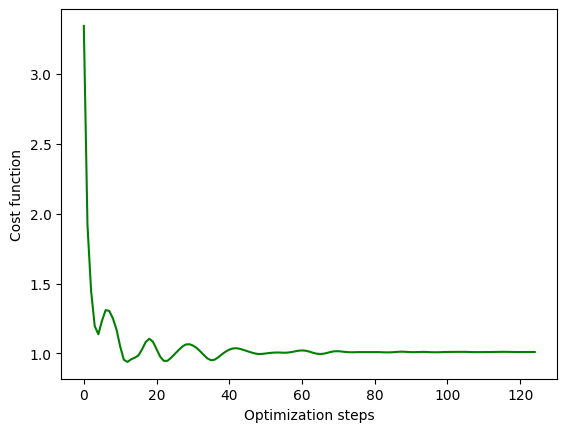

In [17]:
cost_values = [float(c) for c in cost_history]
plt.plot(cost_values, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

In [18]:
print(f"Vector at time n+1 (u_n_plus_1) quantum solver:\n{np.real(ansatz(weights))}\n")

Vector at time n+1 (u_n_plus_1) quantum solver:
[0.04244409 0.02013088 0.03555608 0.05476455 0.07415541 0.09350948
 0.11272795 0.1314883  0.14983468 0.1687512  0.18698014 0.20486357
 0.22249985 0.23994986 0.25488933 0.3025244 ]



Extraordinary results, By doing the first half using the classical solver and then the second half using the quantum solver we were able to reach a less loss than using the quantum solver alone. This gave more accuracy but of course some speed was lost by the classical parts when we go to higher and more complex problems in which quantum is faster and scales better.

To make things even fair, we have ran the quantum solver for half of the iterations = 125 and not 250 as for the full solution previously.

### Innovation Bonus: VQE Variant
To solve the pde using VQE, we need to find the ground state energy of this hamiltonian $H = A†(I - |b⟩⟨b|)A$.

The solution is encoded in the eigenvalue of $H$ with a value of zero.
$H|x\rangle = A†(I - |b⟩⟨b|)A|x\rangle = A†(I - |b⟩⟨b|)|b\rangle = A†(|b⟩ - |b⟩) = 0$


In [19]:
# The identity matrix I should have the same dimension as A
I = np.identity(n) # Use n (which is 16) for the dimension
# Note: U_n should ideally be normalized to represent a quantum state |b⟩
# For the VQE approach with H = A†(I - |b⟩⟨b|)A, |b⟩ is the normalized vector U_n

# Calculate the outer product |b⟩⟨b| which is U_n * U_n.conj().T
# For 1D arrays in numpy/pennylane, the outer product can be calculated this way:
U_n_outer_product = np.outer(U_n, U_n.conj())

# Construct the Hamiltonian H
# Ensure matrix multiplication is used correctly with PennyLane numpy
H = A.conj().T @ (I - U_n_outer_product) @ A

print("Shape of H:", H.shape)
print("Hamiltonian H (first 5x5):\n", H[:16,:16])

Shape of H: (16, 16)
Hamiltonian H (first 5x5):
 [[ 0.9952288  -0.00345428 -0.00856132 -0.0093593  -0.01267777 -0.01597844
  -0.01925455 -0.02250098 -0.02571272 -0.02888481 -0.03201236 -0.03509058
  -0.03811402 -0.04109231 -0.04373391 -0.05178863]
 [-0.00345428  1.003359   -0.00287951 -0.00694626 -0.00602274 -0.00759077
  -0.00914713 -0.01068939 -0.01221517 -0.01372211 -0.01520789 -0.01667024
  -0.01810657 -0.01952145 -0.02077637 -0.02460287]
 [-0.00856132 -0.00287951  0.99994725 -0.00780197 -0.01306827 -0.01331972
  -0.01605071 -0.01875696 -0.02143428 -0.02407855 -0.0266857  -0.02925172
  -0.03177208 -0.03425481 -0.03645685 -0.04317132]
 [-0.0093593  -0.00694626 -0.00780197  0.99295297 -0.01631848 -0.02306701
  -0.02478394 -0.02896266 -0.03309672 -0.03717974 -0.04120544 -0.04516764
  -0.04905933 -0.05289291 -0.0562931  -0.06666093]
 [-0.01267777 -0.00602274 -0.01306827 -0.01631848  0.98289557 -0.02785934
  -0.03607144 -0.03923178 -0.04483163 -0.05036235 -0.05581542 -0.06118248
  -0.06

In [20]:
dev_vqe = qml.device("default.qubit", wires=4)
@qml.qnode(dev_vqe)
# Modify circuit to accept weights as a parameter
def circuit2(weights):
    qml.StronglyEntanglingLayers(weights, wires = range(4))
    return qml.expval(qml.Hermitian(H, wires=[0,1,2,3]))

In [21]:
weights_shape = qml.StronglyEntanglingLayers.shape(n_layers=10, n_wires=4)
initial_weights = np.random.rand(*weights_shape)
weights = qml.numpy.array(initial_weights, requires_grad=True)

In [22]:
# Modify cost_fn to pass the received parameter (weights) to the circuit
def cost_fn(weights):
    x = circuit2(weights)
    return x

In [23]:
optimizer = qml.AdamOptimizer(stepsize=0.1)

In [ ]:
epochs = 100
cost_history = []
for epoch in range(epochs):
    weights, current_cost = optimizer.step_and_cost(cost_fn, weights)
    cost_history.append(current_cost)
    print(f"Epoch {epoch + 1}/{epochs}, Cost: {current_cost:.4f}")

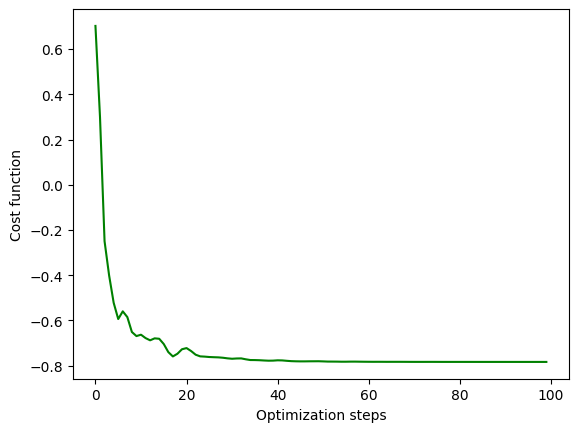

In [25]:
cost_values = [float(c) for c in cost_history]
plt.plot(cost_values, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

Now we print the vector we got after VQE and that from the previous classical solver, we see the values in both vectors are near. So our solution worked.

It is worth mentioning that the VQE has the problem of phase as we cannot always know what the phase is, because of that we see the values as a minus sign. But since c in the pde equals 1 a positive value, so x_values should go forward and not backward so we should multiply the results by -1.

In [26]:
@qml.qnode(dev_vqe)
def circuit_fn_state(params):
    qml.StronglyEntanglingLayers(weights, wires = range(4))
    return qml.state()
np.real(circuit_fn_state(weights))

tensor([-0.05595254, -0.02689388, -0.04706056, -0.07169764, -0.09696248,
        -0.12271294, -0.14713954, -0.17234516, -0.1966561 , -0.22067666,
        -0.24419738, -0.26934797, -0.29129247, -0.31495753, -0.33522538,
        -0.39581463], requires_grad=True)

In [27]:
print(f"Vector at time n+1 (u_n_plus_1) classical solver ---Normalized---:\n{u_n_plus_1/np.linalg.norm(u_n_plus_1)}\n")

Vector at time n+1 (u_n_plus_1) classical solver ---Normalized---:
[0.06535587 0.02987076 0.05599823 0.08511461 0.11425314 0.14322314
 0.17197269 0.20045708 0.22863239 0.25645516 0.28388249 0.31087225
 0.33737967 0.36342675 0.38771306 0.43546922]



### Conclusion:
We were successfully able to first discretize the pde then solve it using quanutm, classical and hybrid approaches reaching near values in the final vector solutions. Also, we added the VQE algorithm as an extra step for bonus.

### References:

1. A brief overview of vqe - pennylane: https://pennylane.ai/qml/demos/tutorial_vqe

2. Poisson 1D solution using VQE: https://github.com/comp-physics/qce23-qpde-tutorial/blob/master/Session2%20Notebook/1DPoisson%2BVQE.ipynb

3. Variational quantum linear solver pennylane tutorials: https://pennylane.ai/qml/demos/tutorial_vqls

4. Other AI tools like gemini and chatgpt and online search results was of great help in addition to some youtube videos and the pennylane functions source code and usage was very extremely helpfull and important.